In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path="/content/drive/MyDrive/dataset1/80-20.zip"

with zipfile.ZipFile(zip_path,'r') as zip_ref:
 zip_ref.extractall("/content/drive/MyDrive/datasetiv380")

In [ ]:
import os
os.listdir("/content/drive/MyDrive/datasetiv380")

['80-20']

In [ ]:
pip install tensorflow.keras

In [ ]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set paths
train_path = '/content/drive/MyDrive/datasetiv380/80-20/train'
test_path = '/content/drive/MyDrive/datasetiv380/80-20/test'

In [ ]:
# Classes
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Dolphin', 'Fish', 'Jelly Fish', 'Octopus', 'Penguin', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Sharks', 'Starfish', 'Turtle_Tortoise', 'Whale', 'crab']


In [ ]:
# ImageDataGenerators
image_size = (299, 299)  # InceptionV3 default input size
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 4080 images belonging to 13 classes.
Found 1120 images belonging to 13 classes.


In [ ]:
def show_images(data, GRID=[6,5], size=(20,25), model=None, class_names=class_names):

    # Plot Details
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols

    # Configure the plot size.
    plt.figure(figsize=size)

    # Data
    images, labels = next(iter(data))

    # Do not repeat id
    ids = []

    # Plot Data
    for i in range(1, n_images+1):

        # Select Random Image and Label
        id = np.random.randint(len(images))
        if id in ids:
            id = np.random.randint(len(images))
        ids.append(id)
        image, label = images[id], class_names[int(labels[id])]

        # Plot The Image
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')

        # Select Title
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label} \nPred : {pred}"
        plt.title(title)


    # Show Plot
    plt.show()

In [ ]:
# Define image size and batch size (these values are taken from a later cell)
image_size = (250, 250)
batch_size = 32

# Create the training data generator (taken from a later cell)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

# Now call the show_images function with the defined train_ds
show_images(data=train_ds)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Build model using InceptionV3
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,330,669 (85.18 MB)

 Trainable params: 527,885 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Callbacks
model_name = "/content/drive/MyDrive/inceptionv3_trained.h5"

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(model_name, save_best_only=True)
]


In [ ]:
# Train model
history = model.fit(train_gen, epochs=10, callbacks=callbacks)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1034s 8s/step - accuracy: 0.4907 - loss: 1.7607
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1039s 8s/step - accuracy: 0.8177 - loss: 0.6271
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1055s 8s/step - accuracy: 0.8426 - loss: 0.4976
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1016s 8s/step - accuracy: 0.8686 - loss: 0.4411
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1024s 8s/step - accuracy: 0.8656 - loss: 0.3923
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1024s 8s/step - accuracy: 0.8826 - loss: 0.3595
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1035s 8s/step - accuracy: 0.8874 - loss: 0.3442
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1046s 8s/step - accuracy: 0.8965 - loss: 0.3214
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1059s 8s/step - accuracy: 0.9043 - loss: 0.2908
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1022s 8s/step - accuracy: 0.9082 - loss: 0.2923


In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.8593 - loss: 0.4945
Test Accuracy: 85.45%


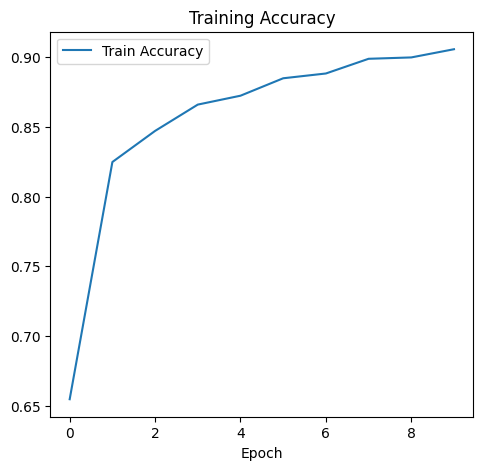

In [ ]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.legend()

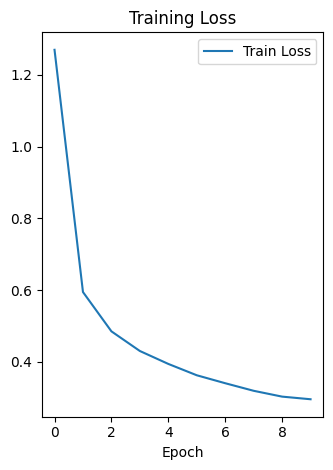

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step

----- Final Evaluation Metrics -----
✅ Test Accuracy   : 85.45%
✅ Precision       : 85.79%
✅ Recall          : 85.45%
✅ F1 Score        : 85.48%


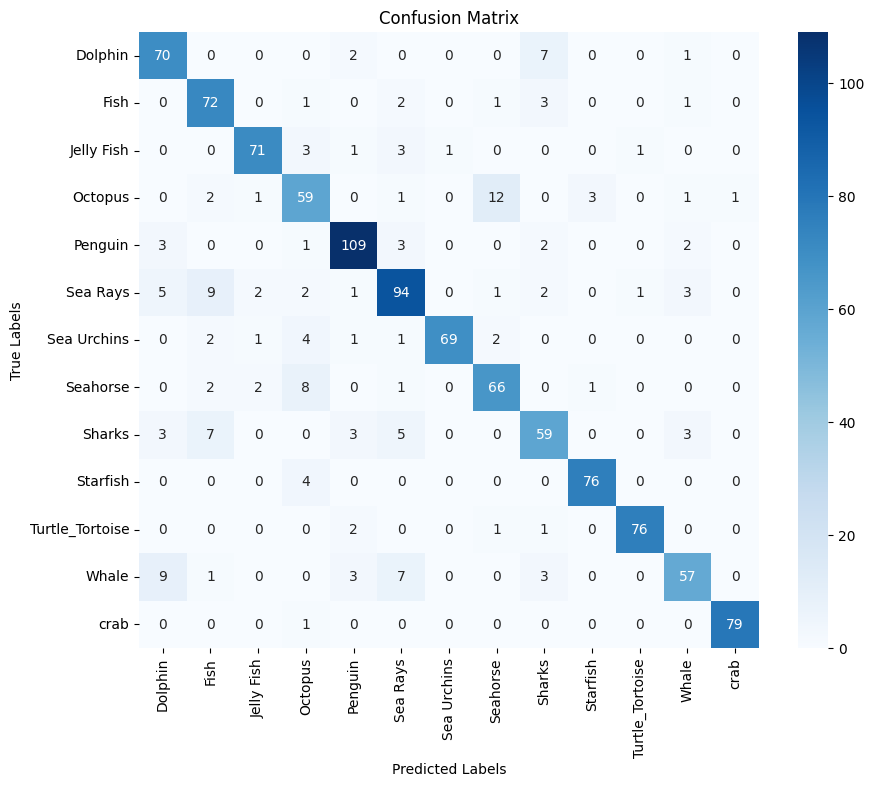


Classification Report:
                 precision    recall  f1-score   support

        Dolphin       0.78      0.88      0.82        80
           Fish       0.76      0.90      0.82        80
     Jelly Fish       0.92      0.89      0.90        80
        Octopus       0.71      0.74      0.72        80
        Penguin       0.89      0.91      0.90       120
       Sea Rays       0.80      0.78      0.79       120
    Sea Urchins       0.99      0.86      0.92        80
       Seahorse       0.80      0.82      0.81        80
         Sharks       0.77      0.74      0.75        80
       Starfish       0.95      0.95      0.95        80
Turtle_Tortoise       0.97      0.95      0.96        80
          Whale       0.84      0.71      0.77        80
           crab       0.99      0.99      0.99        80

       accuracy                           0.85      1120
      macro avg       0.86      0.86      0.86      1120
   weighted avg       0.86      0.85      0.85      1120



In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load true labels and predictions
true_labels = test_gen.classes
predictions = model.predict(test_gen, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Step 3: Output metrics
print("\n----- Final Evaluation Metrics -----")
print(f"✅ Test Accuracy   : {accuracy * 100:.2f}%")
print(f"✅ Precision       : {precision * 100:.2f}%")
print(f"✅ Recall          : {recall * 100:.2f}%")
print(f"✅ F1 Score        : {f1 * 100:.2f}%")

# Step 4: Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


In [ ]:
import numpy as np

# Make predictions
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)  # Get predicted class indices
true_classes = test_gen.classes                     # Get true class indices
class_labels = list(test_gen.class_indices.keys())  # Class names


35/35 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step


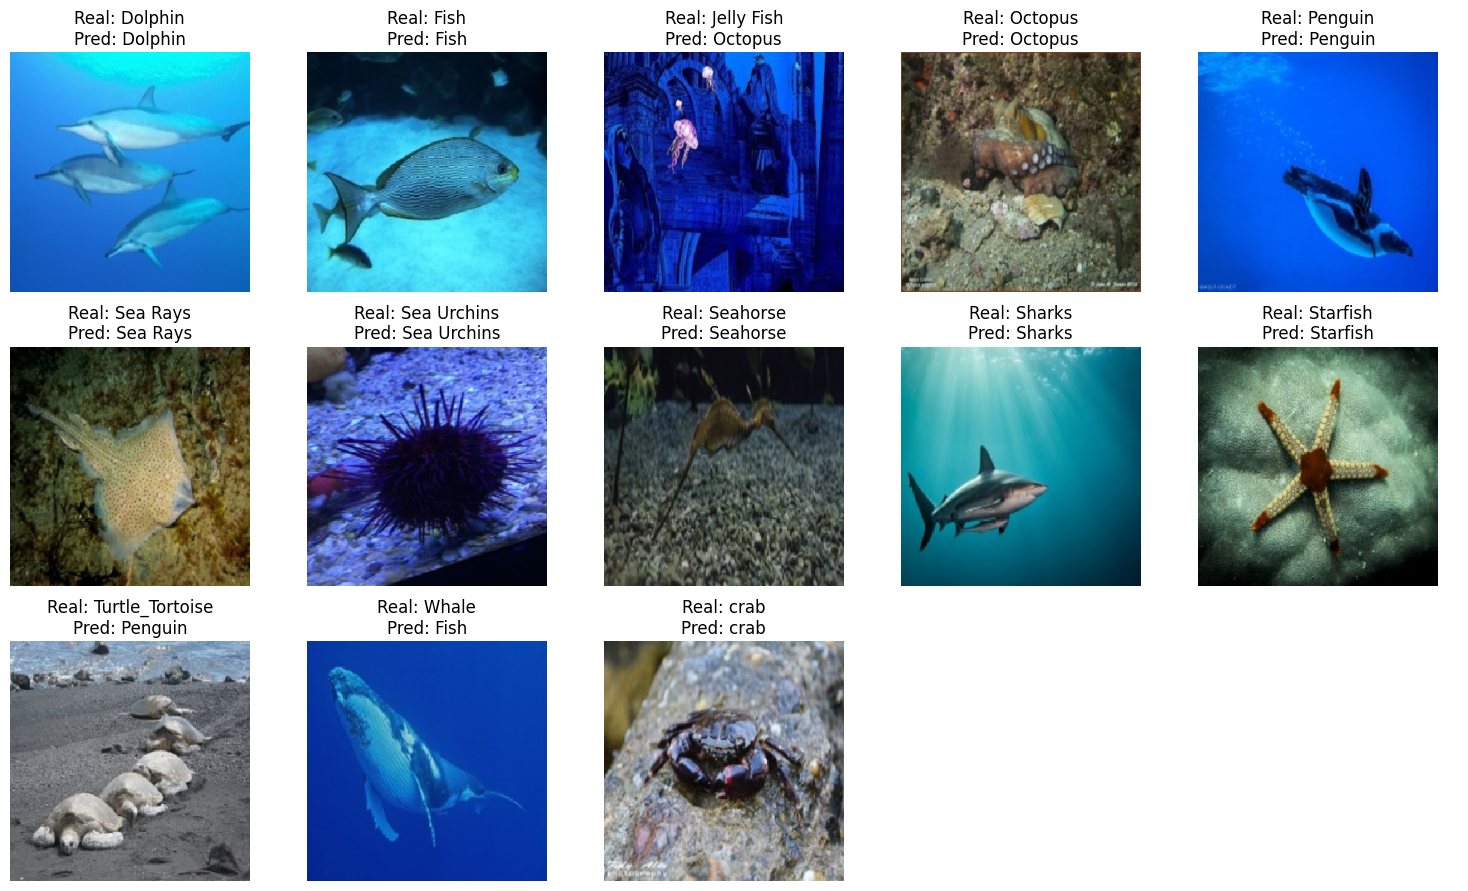

In [ ]:
import math

# === STEP 5: Plot the results ===
num_samples = len(sample_images)
cols = 5
rows = math.ceil(num_samples / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for i in range(len(sample_images)):
    axes[i].imshow(sample_images[i])
    axes[i].set_title(f"Real: {sample_true_labels[i]}\nPred: {sample_predicted_labels[i]}")
    axes[i].axis('off')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# === STEP 5: Evaluate and Save Final Model ===

final_model_path = "/content/drive/MyDrive/inceptionv3_final_80_20.h5"
model.save(final_model_path)
print("✅ Model saved successfully.")

✅ Model saved successfully.


In [ ]:
# === STEP 6: Load and Predict ===
from tensorflow.keras.models import load_model
model = load_model(final_model_path)

import numpy as np
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

35/35 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step


In [ ]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = "/content/drive/MyDrive/inceptionv3_final_80_20.h5"
model = load_model(model_path)
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [ ]:
# Get base model (first layer in Sequential)
base_model = model.layers[0]
base_model.trainable = True  # Unfreeze entire base model (or partial below)

# Optional: Unfreeze only top N layers
fine_tune_at = 250
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✅ Unfroze top {len(base_model.layers) - fine_tune_at} layers.")


✅ Unfroze top 61 layers.


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Recompiled with low LR for fine-tuning.")


✅ Recompiled with low LR for fine-tuning.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (299, 299)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/datasetiv380/80-20/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/datasetiv380/80-20/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 4080 images belonging to 13 classes.
Found 1120 images belonging to 13 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

fine_tuned_path = "/content/drive/MyDrive/inceptionv3_finetuned.h5"

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(fine_tuned_path, save_best_only=True)
]

history_ft = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8349 - loss: 0.5225 

128/128 ━━━━━━━━━━━━━━━━━━━━ 3376s 26s/step - accuracy: 0.8351 - loss: 0.5220 - val_accuracy: 0.8643 - val_loss: 0.4873
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8992 - loss: 0.3365

128/128 ━━━━━━━━━━━━━━━━━━━━ 135s 906ms/step - accuracy: 0.8992 - loss: 0.3365 - val_accuracy: 0.8643 - val_loss: 0.4700
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.9234 - loss: 0.2678

128/128 ━━━━━━━━━━━━━━━━━━━━ 119s 932ms/step - accuracy: 0.9233 - loss: 0.2679 - val_accuracy: 0.8661 - val_loss: 0.4555
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9258 - loss: 0.2408

128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 926ms/step - accuracy: 0.9258 - loss: 0.2408 - val_accuracy: 0.8687 - val_loss: 0.4466
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9432 - loss: 0.1922

128/128 ━━━━━━━━━━━━━━━━━━━━ 121s 942ms/step - accuracy: 0.9431 - loss: 0.1923 - val_accuracy: 0.8768 - val_loss: 0.4343
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 118s 919ms/step - accuracy: 0.9491 - loss: 0.1736 - val_accuracy: 0.8759 - val_loss: 0.4355
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9457 - loss: 0.1872

128/128 ━━━━━━━━━━━━━━━━━━━━ 139s 902ms/step - accuracy: 0.9458 - loss: 0.1871 - val_accuracy: 0.8750 - val_loss: 0.4284
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9549 - loss: 0.1505

128/128 ━━━━━━━━━━━━━━━━━━━━ 119s 929ms/step - accuracy: 0.9549 - loss: 0.1505 - val_accuracy: 0.8804 - val_loss: 0.4274
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 117s 917ms/step - accuracy: 0.9598 - loss: 0.1353 - val_accuracy: 0.8813 - val_loss: 0.4287
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 113s 884ms/step - accuracy: 0.9700 - loss: 0.1128 - val_accuracy: 0.8777 - val_loss: 0.4287


In [ ]:
loss, accuracy = model.evaluate(test_gen, verbose=1)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8789 - loss: 0.4380
✅ Test Accuracy: 88.04%


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step
                 precision    recall  f1-score   support

        Dolphin       0.86      0.95      0.90        80
           Fish       0.87      0.89      0.88        80
     Jelly Fish       0.96      0.88      0.92        80
        Octopus       0.79      0.70      0.74        80
        Penguin       0.95      0.88      0.91       120
       Sea Rays       0.86      0.84      0.85       120
    Sea Urchins       0.97      0.84      0.90        80
       Seahorse       0.75      0.96      0.84        80
         Sharks       0.82      0.78      0.79        80
       Starfish       0.94      0.97      0.96        80
Turtle_Tortoise       0.93      0.96      0.94        80
          Whale       0.84      0.84      0.84        80
           crab       0.94      0.97      0.96        80

       accuracy                           0.88      1120
      macro avg       0.88      0.88      0.88      1120
   weighted avg       0.88      0.88      0.

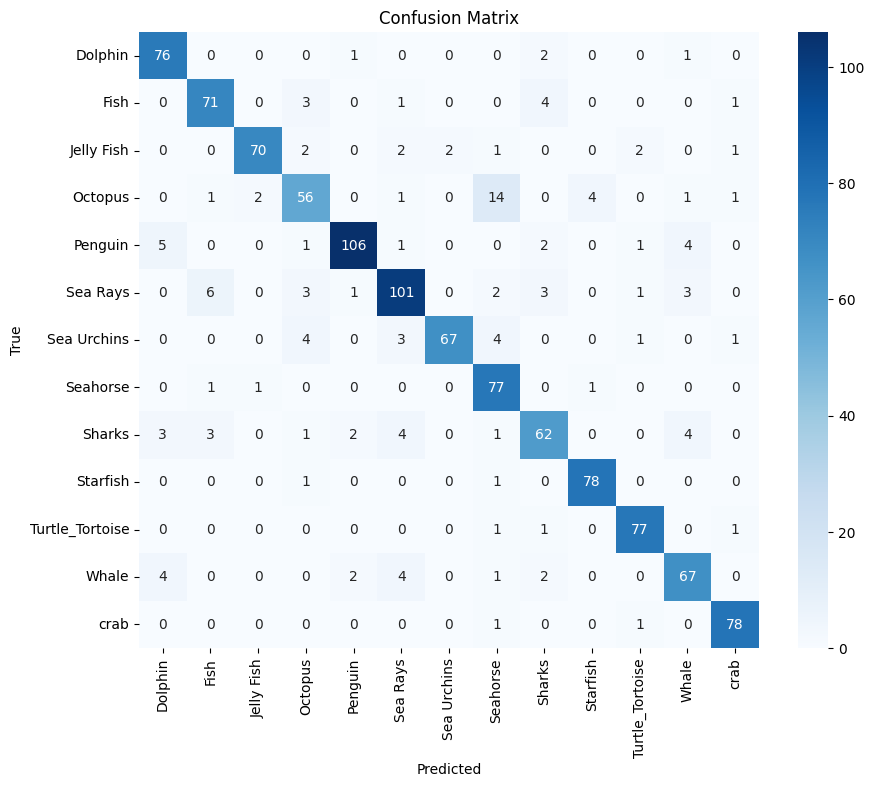

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Print report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/inceptionv3_finetuned.h5")
print("✅ Model saved successfully.")


✅ Model saved successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_single_image(img_path, model, class_names):
    # Load and resize image
    img = image.load_img(img_path, target_size=(299, 299))

    # Convert image to array
    img_array = image.img_to_array(img)

    # Expand dimensions to match model input (1, 299, 299, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image (InceptionV3 expects preprocessing)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class


In [ ]:
import os

# Redefine train_path
train_path = '/content/drive/MyDrive/dataset80/80-20/train'

# Then get class names
class_names = sorted(os.listdir(train_path))


In [ ]:
import os

# Define class names in correct order by listing directories in the training path
train_path = '/content/drive/MyDrive/datasetiv380/80-20/train'
class_names = sorted(os.listdir(train_path))

print("Class names derived from training directory:")
print(class_names)

Class names derived from training directory:
['Dolphin', 'Fish', 'Jelly Fish', 'Octopus', 'Penguin', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Sharks', 'Starfish', 'Turtle_Tortoise', 'Whale', 'crab']


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


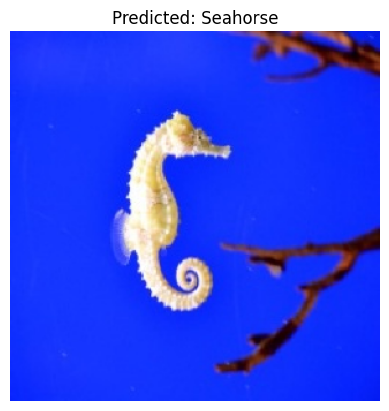

✅ Predicted class: Seahorse


'Seahorse'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os # Import os module to use os.listdir

# === Step 1: Load the model ===
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/inceptionv3_finetuned.h5")

# === Step 2: Define class names in correct order ===
# (Must match order of class folders in training directory)
# Using class_names defined in cell BJEighoq3fEG
# class_names = sorted(os.listdir('/content/drive/MyDrive/datasetiv380/80-20/train'))  # or wherever your training data is

# === Step 3: Load and preprocess the image ===
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# === Step 4: Predict and show results ===
def predict_single_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]

    # Show image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()

    print(f"✅ Predicted class: {predicted_class_name}")
    return predicted_class_name

# === Step 5: Run prediction on your image ===
# Example image path (change this to your actual image path)
img_path = "/content/drive/MyDrive/datasetiv380/80-20/test/Seahorse/8006280214_6a19d58157_o.jpg"  # Replace with your own image path
predict_single_image(img_path)